# Import de fonctions

In [1]:
import sys
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score as ARI
from scipy.ndimage import gaussian_filter1d


# import UCSL github : Unsupervised Clustering driven by Supervised Learning 
!git clone https://github.com/rlouiset/py_ucsl > /dev/null 2>&1

sys.path.append('./py_ucsl/')
from ucsl.ucsl_classifier import *
from ucsl.ucsl_regressor import *


In [2]:
colors = np.array(list(['#377eb8', '#ff7f00', '#4daf4a',
                        '#f781bf', '#a65628', '#984ea3',
                        '#999999', '#e41a1c', '#dede00']))

def one_hot_encode(y, n_classes=None):
    ''' utils function in order to turn a label vector into a one hot encoded matrix '''
    if n_classes is None :
        n_classes = np.max(y)+1
    y_one_hot = np.copy(y)
    return np.eye(n_classes)[y_one_hot]


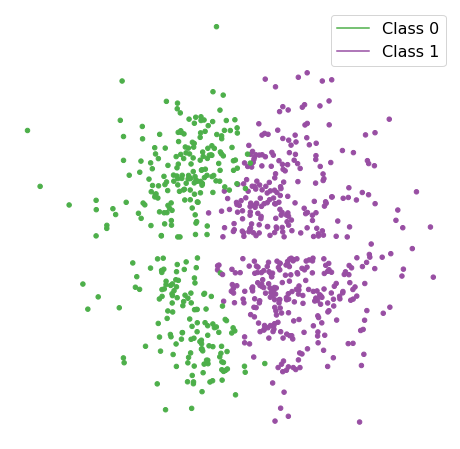

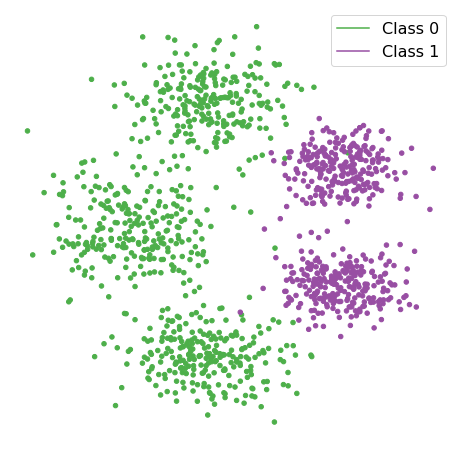

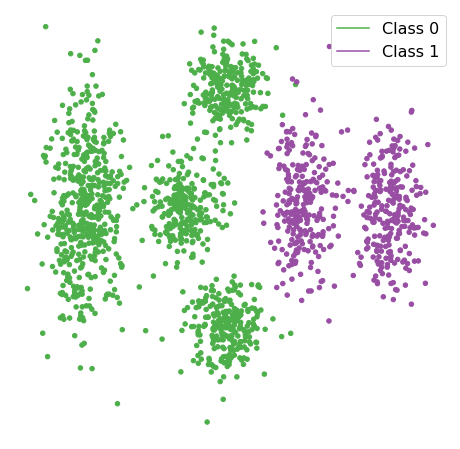

In [3]:
# convexity / concavity binary synthetic example with clusters along classification boundary
def make_convex_concave_binary_dataset(n_samples=900, boundary_convexity=0.7, boundary_peak=5, boundary_translation=1.5, intra_clustering_limit=5, noise_dimensions=0, plot=True,
                       title="Classification / Unsupervised Toy Example ") :
  ''' make a dataset \w ground-truth labels and ntra-class clustering '''
  noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
  blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
  no_structure = np.random.rand(n_samples, 2), None

  polytope, y_moons = noisy_moons
  custom_boundary = polytope[y_moons==0]

  normal_distribution = np.random.normal(np.mean(custom_boundary), 3, size=(n_samples-200,2))
  X_train = []
  for point in normal_distribution :
    dist_point_boundary = np.min(np.abs(custom_boundary[custom_boundary[:,0]<0]-np.array(point)[None,:]))
    if dist_point_boundary > (0.005*np.abs(np.random.normal(0, 0.2))) :
      if point[0] < intra_clustering_limit :                                                                   
        point[1] = point[1] + point[1]/np.abs(point[1])*0.5
      X_train.append(point)
  X_train = np.array(X_train)

  y_train = []
  for point in X_train :
    if (point[0] + np.abs(np.random.uniform(1, max(0, boundary_peak-boundary_convexity*np.abs(point[1]))))-1) > 0 :
      y_train.append(0)
    else :
      y_train.append(1)
  y_train=np.array(y_train)
  X_train[y_train==0,0] = X_train[y_train==0,0] + boundary_translation

  to_add = 100
  gaussian_blob_1 = np.random.normal(0, 1.1, size=(to_add//2, 2)) + np.array([-1, 5])
  gaussian_blob_2 = np.random.normal(0, 1, size=(to_add//2, 2)) + np.array([-1, -5])

  y_train = np.concatenate((y_train, np.array(to_add*[1])))
  X_train = np.concatenate((X_train, gaussian_blob_1), 0)
  X_train = np.concatenate((X_train, gaussian_blob_2), 0)
  X_train = StandardScaler().fit_transform(X_train)

  
  y_cluster = {label:[0]*np.sum(y_train==label) for label in np.unique(y_train)}
  for label in np.unique(y_train) :
    k_means_method = KMeans(n_clusters=2)
    y_cluster[label] = k_means_method.fit_predict(X_train[y_train==label])

  for noise_dim in range(0, noise_dimensions) :
    X_train = np.concatenate((X_train, np.random.normal(0, 1, size=(X_train.shape[0], 1))), 1)
  
  if plot : 
    y_color = 2*y_train.copy()
    for label in np.unique(y_train) :
      y_color[y_train==label] += y_cluster[label]
    y_color = -3*y_train-4
    
    custom_legend = [Line2D([0], [0], color=colors[-7]), Line2D([0], [0], color=colors[-4])]
    custom_labels = ['Class 0', 'Class 1']

    plt.figure(figsize=(8,8))
    plt.scatter(X_train[:, 0], X_train[:, 1], s=20, color=colors[y_color])
    plt.legend(custom_legend, custom_labels, prop={'size': 16})
    plt.axis('off')
    plt.show()
    
  return X_train, y_train, y_cluster
_ = make_convex_concave_binary_dataset(plot=True)

# convexity / concavity with multiple clusters along classification boundary synthetic example
def make_gaussian_convex_concave_dataset(plot = True, noise_dimensions=0, noise_intensity=1, blob_size=250, title = 'Gaussian Toy Example') :
  blob_1 = np.array([-0.35, 0]) + np.random.normal(0, .2, size=(blob_size, 2))
  blob_1[:,1] *= 1.25
  blob_2 = np.array([0, 1]) + np.random.normal(0, .2, size=(blob_size, 2))
  blob_3 = np.array([0, -1]) + np.random.normal(0, .2, size=(blob_size, 2))
  blob_4 = np.array([0.65, 0.45]) + np.random.normal(0, .15, size=(blob_size, 2))
  blob_5 = np.array([0.65, -0.45]) + np.random.normal(0, .15, size=(blob_size, 2))

  X_train = np.concatenate((blob_1, blob_2, blob_3, blob_4, blob_5), 0)  
  X_train = X_train / np.std(X_train)
  y_train = np.concatenate((3*blob_size*[1], 2*blob_size*[0]), 0)

  GMM = {0:GaussianMixture(n_components=2), 1:GaussianMixture(n_components=3) }
  y_cluster = {label:GMM[label].fit_predict(X_train[y_train==label]) for label in [0,1]}
 
  for noise_dim in range(0, noise_dimensions) :
    X_train = np.concatenate((X_train, np.random.normal(0, noise_intensity, size=(X_train.shape[0], 1))), 1)
  
  if plot : 
    y_color = 2*y_train.copy()
    for label in np.unique(y_train) :
      y_color[y_train==label] += y_cluster[label]
    y_color = -3*y_train-4
    
    custom_legend = [Line2D([0], [0], color=colors[-7]), Line2D([0], [0], color=colors[-4])]
    custom_labels = ['Class 0', 'Class 1']
    plt.figure(figsize=(8,8))
    plt.scatter(X_train[:, 0], X_train[:, 1], s=20, color=colors[y_color])
    plt.legend(custom_legend, custom_labels, prop={'size': 16})
    plt.axis('off')
    plt.show()

  return X_train, y_train, y_cluster
_ = make_gaussian_convex_concave_dataset(plot=True)

# convexity / concavity with multiple clusters orthogonal to classification boundary synthetic example
def make_gaussian_parallel_convex_concave_dataset(plot = True, noise_dimensions=0, blob_size=250, title = 'Gaussian Toy Example') :
  #blob_1 = np.array([-0.25, 0]) + np.random.normal(0, .16, size=(blob_size, 2))
  #blob_1[:,1] *= 1.5
  #blob_2 = np.array([0, 1]) + np.random.normal(0, .16, size=(blob_size, 2))
  #blob_3 = np.array([0, -1]) + np.random.normal(0, .16, size=(blob_size, 2))
  blob_1 = np.array([-1.05, 0]) + np.random.normal(0, .15, size=(2*blob_size, 2))
  blob_1[:,1] *= 2.5
  blob_2 = np.array([0.1, 0.75]) + np.random.normal(0, .15, size=(blob_size, 2))
  blob_3 = np.array([0.1, -0.75]) + np.random.normal(0, .15, size=(blob_size, 2))
  blob_6 = np.array([-0.25, 0]) + np.random.normal(0, .15, size=(blob_size, 2))

  blob_4 = np.array([0.7, 0.0]) + np.random.normal(0, .13, size=(blob_size, 2))
  blob_4[:,1] *= 2
  blob_5 = np.array([6.4, 0.0]) + np.random.normal(0, .13, size=(blob_size, 2)) 
  blob_5[:,1] *= 2


  X_train = np.concatenate((blob_1, blob_2, blob_3, blob_6, blob_4, blob_5), 0)  
  y_train = np.concatenate((5*blob_size*[1], 2*blob_size*[0]), 0)

  GMM = {0:GaussianMixture(n_components=2), 1:  GaussianMixture(n_components=4) }
  y_cluster = {label:GMM[label].fit_predict(X_train[y_train==label]) for label in [0,1]}
  X_train[-blob_size:,0] -= 5
  X_train = X_train / np.std(X_train)

  for noise_dim in range(0, noise_dimensions) :
    X_train = np.concatenate((X_train, np.random.normal(0, 1, size=(X_train.shape[0], 1))), 1)
  
  if plot : 
    y_color = 2*y_train.copy()
    for label in np.unique(y_train) :
      y_color[y_train==label] += y_cluster[label]
    y_color = -3*y_train-4
    
    custom_legend = [Line2D([0], [0], color=colors[-7]), Line2D([0], [0], color=colors[-4])]
    custom_labels = ['Class 0', 'Class 1']
    plt.figure(figsize=(8,8))
    plt.scatter(X_train[:, 0], X_train[:, 1], s=20, color=colors[y_color])
    plt.legend(custom_legend, custom_labels, prop={'size': 16})
    plt.axis('off')
    plt.show()
  
  return X_train, y_train, y_cluster

_ = make_gaussian_parallel_convex_concave_dataset(plot=True)

# Concave / convex binary clustering synthetic dataset

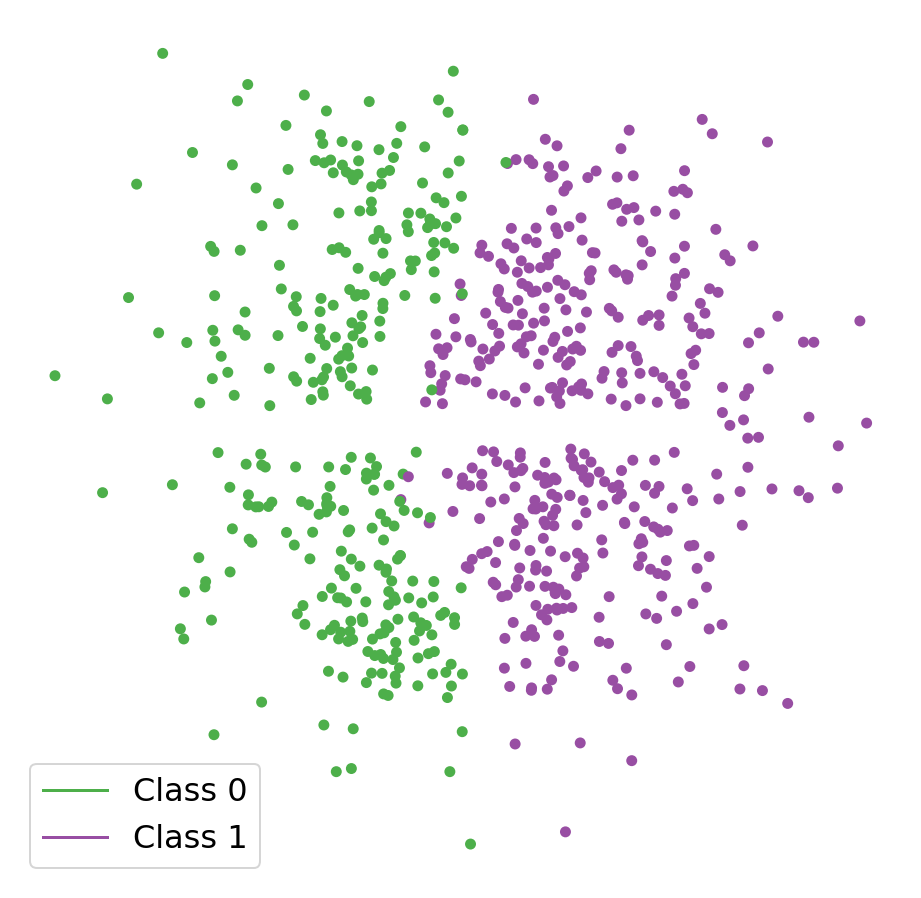

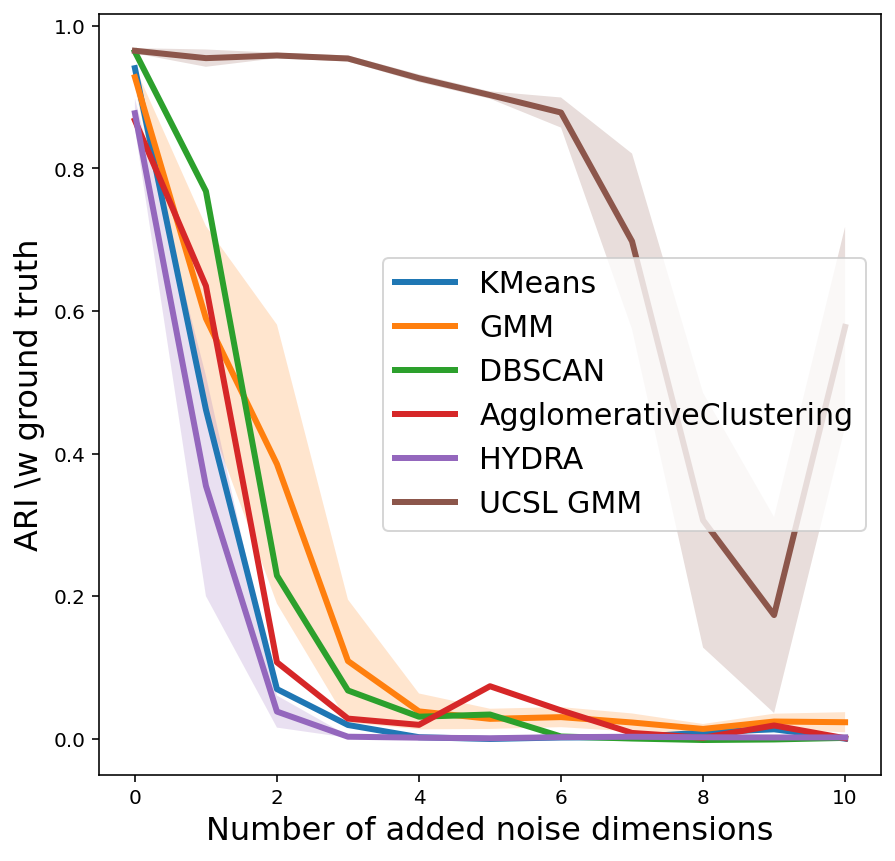

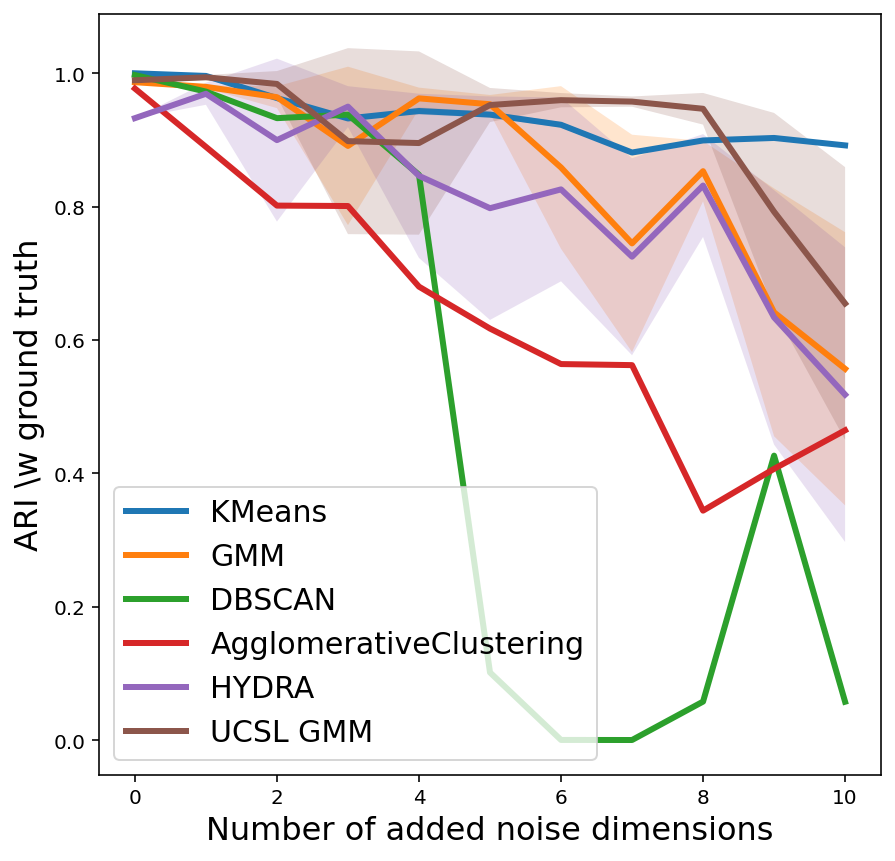

In [16]:
noise_dimensions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dict_metrics = {
                0:{"KMeans":{"mean_list":[], "std_list":[]}, 
                   "GMM":{"mean_list":[], "std_list":[]}, 
                   "DBSCAN":{"mean_list":[], "std_list":[]}, 
                   "AgglomerativeClustering":{"mean_list":[], "std_list":[]}, 
                   "HYDRA":{"mean_list":[], "std_list":[]} , 
                   "UCSL GMM":{"mean_list":[], "std_list":[]} 
                   }, 
                
                1:{"KMeans":{"mean_list":[], "std_list":[]} , 
                   "GMM":{"mean_list":[], "std_list":[]} , 
                   "DBSCAN":{"mean_list":[], "std_list":[]}, 
                   "AgglomerativeClustering":{"mean_list":[], "std_list":[]}, 
                   "HYDRA":{"mean_list":[], "std_list":[]} ,
                   "UCSL GMM":{"mean_list":[], "std_list":[]} 
                   }
               }

n_clusters_per_label={0:2, 1:2}

# dataset creation
X_train, y_train, y_true_cluster = make_convex_concave_binary_dataset(noise_dimensions=0, intra_clustering_limit=5, plot=True)
print("")

for noise_dimension in noise_dimensions :

  if noise_dimension > 0 :
    X_train = np.concatenate((X_train, np.random.normal(0, 1, size=(X_train.shape[0], 1))), 1)

  for clustering_type in ["HYDRA", "GMM", "KMeans", "DBSCAN", "AgglomerativeClustering", "UCSL GMM"] :
    ARIs = {0:[], 1:[]}
    for i in range(1, 10) :
      initialization_matrixes = {}
      initialization_matrixes[0] = np.ones((len(X_train), n_clusters_per_label[0]))/n_clusters_per_label[0]
      initialization_matrixes[1] = np.ones((len(X_train), n_clusters_per_label[1]))/n_clusters_per_label[1]
      
      initialization_matrixes[0][y_train==0] = GaussianMixture(n_components=2, n_init=1).fit(X_train[y_train==0]).predict_proba(X_train[y_train==0])
      initialization_matrixes[1][y_train==1] = GaussianMixture(n_components=2, n_init=1).fit(X_train[y_train==1]).predict_proba(X_train[y_train==1])

      # different method training training
      if clustering_type == 'HYDRA' :
        UCSL_method = UCSL_C(initialization="precomputed", clustering="HYDRA", negative_weighting='all', maximization="max_margin",
                      n_consensus=1, n_clusters_per_label={0:2, 1:2}, custom_initialization_matrixes=initialization_matrixes)
        UCSL_method.fit(X_train, y_train)

      elif clustering_type == 'UCSL GMM' : 
        UCSL_method = UCSL_C(initialization="precomputed",  n_consensus=1, n_iterations=20,
                             n_clusters_per_label={0:2, 1:2}, custom_initialization_matrixes=initialization_matrixes, covariance_type='spherical')
        UCSL_method.fit(X_train, y_train)

      elif clustering_type == 'KMeans' : 
        clustering_method = [KMeans(n_clusters=n_clusters_per_label[i]).fit(X_train[y_train==i]) for i in [0, 1]]

      elif clustering_type == 'GMM' : 
        clustering_method = [GaussianMixture(n_components=n_clusters_per_label[i]).fit(X_train[y_train==i]) for i in [0, 1]]

      for label in [0, 1] :
        if clustering_type in ['HYDRA', 'UCSL GMM'] : 
          y_pred = np.argmax(UCSL_method.predict_clusters(X_train)[label], 1)[y_train==label]
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

        elif clustering_type in ['KMeans', 'GMM'] :
          y_pred = clustering_method[label].predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred)) 

        elif clustering_type in ['DBSCAN'] :
          y_pred = SpectralClustering(n_clusters=n_clusters_per_label[label]).fit_predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

        elif clustering_type in ['AgglomerativeClustering'] :
          y_pred = AgglomerativeClustering(n_clusters=n_clusters_per_label[label]).fit_predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

    for label in [0, 1] :
      dict_metrics[label][clustering_type]["mean_list"].append(np.mean(ARIs[label]))
      dict_metrics[label][clustering_type]["std_list"].append(np.std(ARIs[label]))


%config InlineBackend.figure_format = 'retina'

for label in [0, 1] :
  plt.figure(figsize=(7, 7))
  for clustering_type in ["KMeans", "GMM", "DBSCAN", "AgglomerativeClustering", "HYDRA", "UCSL GMM"] :
    ARI_mean_list = gaussian_filter1d(np.array(dict_metrics[label][clustering_type]["mean_list"]), 0.5)
    ARI_std_list = gaussian_filter1d(np.array(dict_metrics[label][clustering_type]["std_list"]), 0.5) / 2
    plt.plot(noise_dimensions, ARI_mean_list, linestyle='-', label=clustering_type, linewidth=3)
    plt.fill_between(noise_dimensions, ARI_mean_list-ARI_std_list, ARI_mean_list+ARI_std_list, alpha=0.2)
  plt.xlabel("Number of added noise dimensions",  fontsize=16)
  plt.ylabel("ARI \w ground truth",  fontsize=16)
  plt.legend(prop={'size': 15})
  plt.show()
  print('')

# Gaussian concave / convex dataset with clusters along the classification boundary

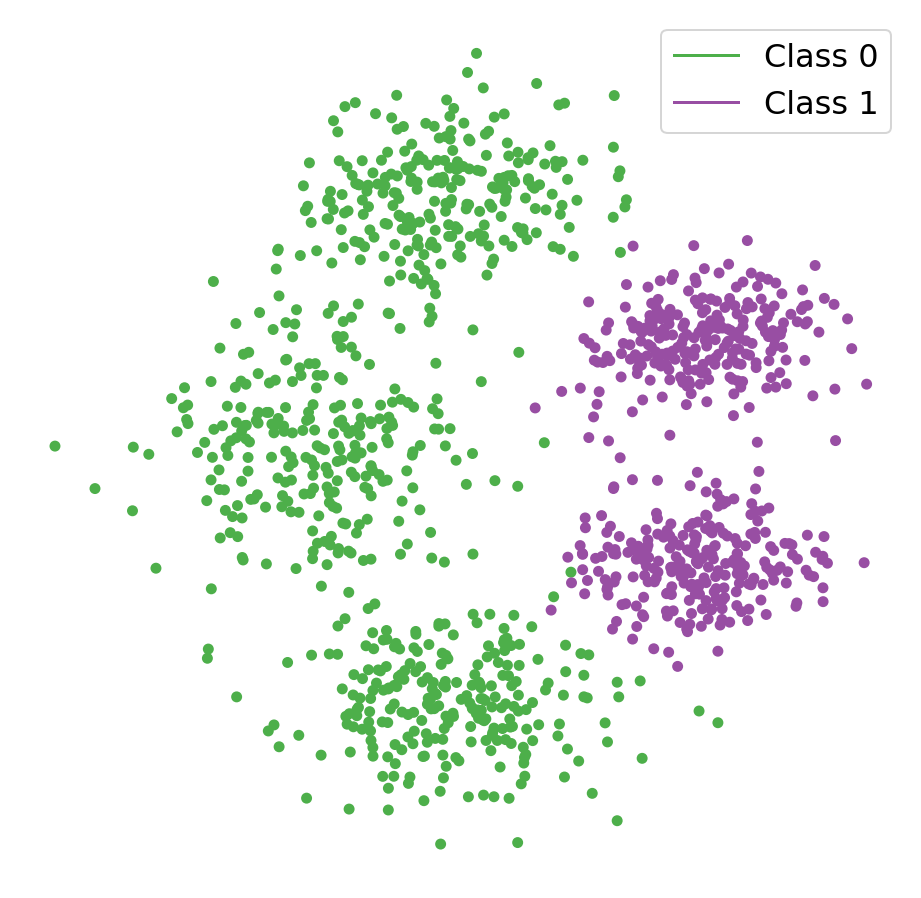

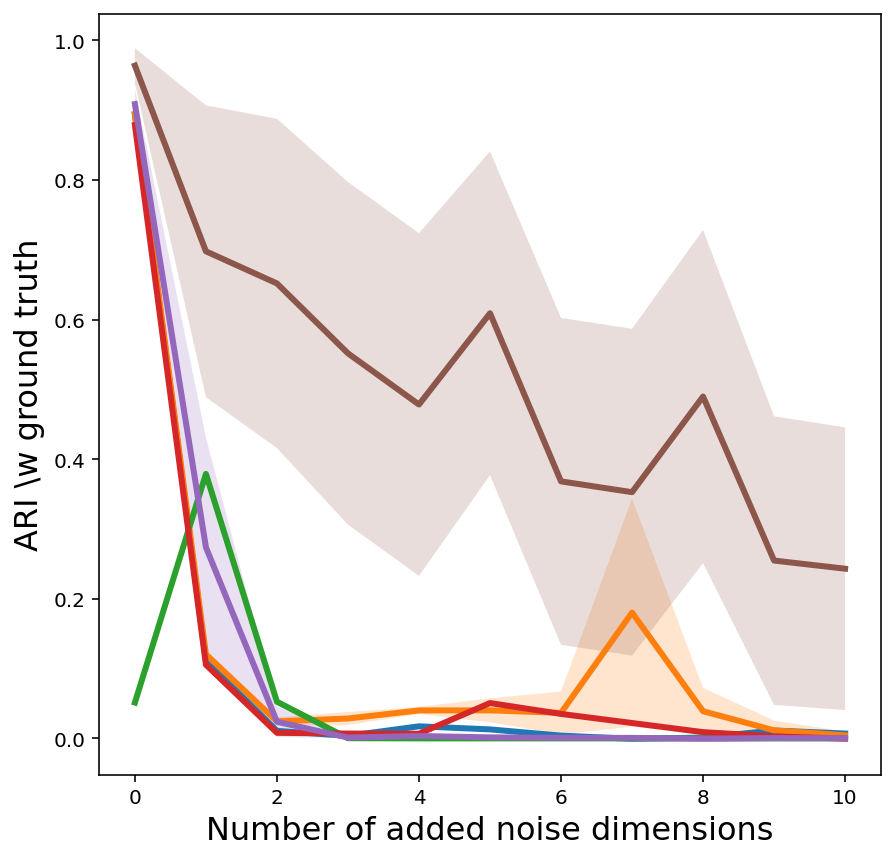

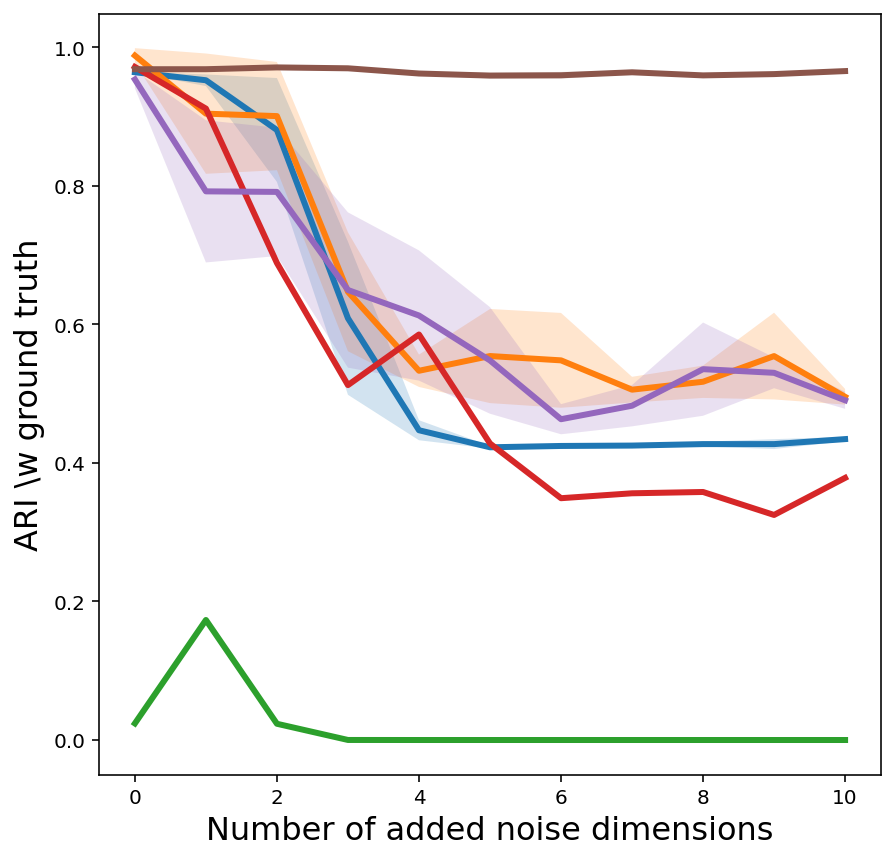

In [11]:
noise_dimensions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dict_metrics = {
                0:{"KMeans":{"mean_list":[], "std_list":[]}, 
                   "GMM":{"mean_list":[], "std_list":[]}, 
                   "DBSCAN":{"mean_list":[], "std_list":[]}, 
                   "AgglomerativeClustering":{"mean_list":[], "std_list":[]}, 
                   "HYDRA":{"mean_list":[], "std_list":[]} , 
                   "UCSL GMM":{"mean_list":[], "std_list":[]} , 
                   }, 
                
                1:{"KMeans":{"mean_list":[], "std_list":[]} , 
                   "GMM":{"mean_list":[], "std_list":[]} , 
                   "DBSCAN":{"mean_list":[], "std_list":[]}, 
                   "AgglomerativeClustering":{"mean_list":[], "std_list":[]}, 
                   "HYDRA":{"mean_list":[], "std_list":[]} ,
                   "UCSL GMM":{"mean_list":[], "std_list":[]} , 
                   }
               }

n_clusters_per_label={0:2, 1:3}


# dataset creation
X_train, y_train, y_true_cluster = make_gaussian_convex_concave_dataset(noise_dimensions=0, plot=True)
print('')

for noise_dimension in noise_dimensions :

  if noise_dimension > 0 :
    X_train = np.concatenate((X_train, np.random.normal(0, 1, size=(X_train.shape[0], 1))), 1)

  for clustering_type in ["HYDRA", "GMM", "KMeans", "DBSCAN", "AgglomerativeClustering", "UCSL GMM"] :
    ARIs = {0:[], 1:[]}
    for i in range(1, 10) :
      initialization_matrixes = {}
      initialization_matrixes[0] = np.ones((len(X_train), n_clusters_per_label[0]))/n_clusters_per_label[0]
      initialization_matrixes[1] = np.ones((len(X_train), n_clusters_per_label[1]))/n_clusters_per_label[1]
      
      initialization_matrixes[0][y_train==0] = GaussianMixture(n_components=2, n_init=1).fit(X_train[y_train==0]).predict_proba(X_train[y_train==0])
      initialization_matrixes[1][y_train==1] = GaussianMixture(n_components=3, n_init=1).fit(X_train[y_train==1]).predict_proba(X_train[y_train==1])

      # different method training
      if clustering_type == 'HYDRA' :
        UCSL_method = UCSL_C(initialization="precomputed", clustering="HYDRA", negative_weighting='all', maximization="max_margin", 
                      n_consensus=1, n_iterations=20, n_clusters_per_label={0:2, 1:3}, custom_initialization_matrixes=initialization_matrixes)
        UCSL_method.fit(X_train, y_train)

      elif clustering_type == 'UCSL GMM' : 
        UCSL_method = UCSL_C(initialization="precomputed", covariance_type='diag', n_consensus=1, n_iterations=20, 
                      n_clusters_per_label={0:2, 1:3}, custom_initialization_matrixes=initialization_matrixes)
        UCSL_method.fit(X_train, y_train)

      elif clustering_type == 'KMeans' : 
        clustering_method = [KMeans(n_clusters=n_clusters_per_label[i]).fit(X_train[y_train==i]) for i in [0, 1]]

      elif clustering_type == 'GMM' : 
        clustering_method = [GaussianMixture(n_components=n_clusters_per_label[i]).fit(X_train[y_train==i]) for i in [0, 1]]

      for label in [0, 1] :
        if clustering_type in ['HYDRA', 'UCSL GMM'] : 
          y_pred = np.argmax(UCSL_method.predict_clusters(X_train)[label], 1)[y_train==label]
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

        elif clustering_type in ['KMeans', 'GMM'] :
          y_pred = clustering_method[label].predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred)) 

        elif clustering_type in ['DBSCAN'] :
          y_pred = DBSCAN(eps=0.25).fit_predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

        elif clustering_type in ['AgglomerativeClustering'] :
          y_pred = AgglomerativeClustering(n_clusters=n_clusters_per_label[label]).fit_predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

    for label in [0, 1] :
      dict_metrics[label][clustering_type]["mean_list"].append(np.mean(ARIs[label]))
      dict_metrics[label][clustering_type]["std_list"].append(np.std(ARIs[label]))

%config InlineBackend.figure_format = 'retina'


for label in [0, 1] :
  plt.figure(figsize=(7, 7))
  for clustering_type in ["KMeans", "GMM", "DBSCAN", "AgglomerativeClustering", "HYDRA", "UCSL GMM"] :
    ARI_mean_list = gaussian_filter1d(np.array(dict_metrics[label][clustering_type]["mean_list"]), 0.5)
    ARI_std_list = gaussian_filter1d(np.array(dict_metrics[label][clustering_type]["std_list"]), 0.5) / 2
    plt.plot(noise_dimensions, ARI_mean_list, linestyle='-', label=clustering_type, linewidth=3)
    plt.fill_between(noise_dimensions, ARI_mean_list-ARI_std_list, ARI_mean_list+ARI_std_list, alpha=0.2)
  plt.xlabel("Number of added noise dimensions",  fontsize=16)
  plt.ylabel("ARI \w ground truth",  fontsize=16)
  #plt.legend(prop={'size': 15})
  plt.show()
  print('')

# Gaussian concave / convex dataset with clusters orthogonal to classification boundary

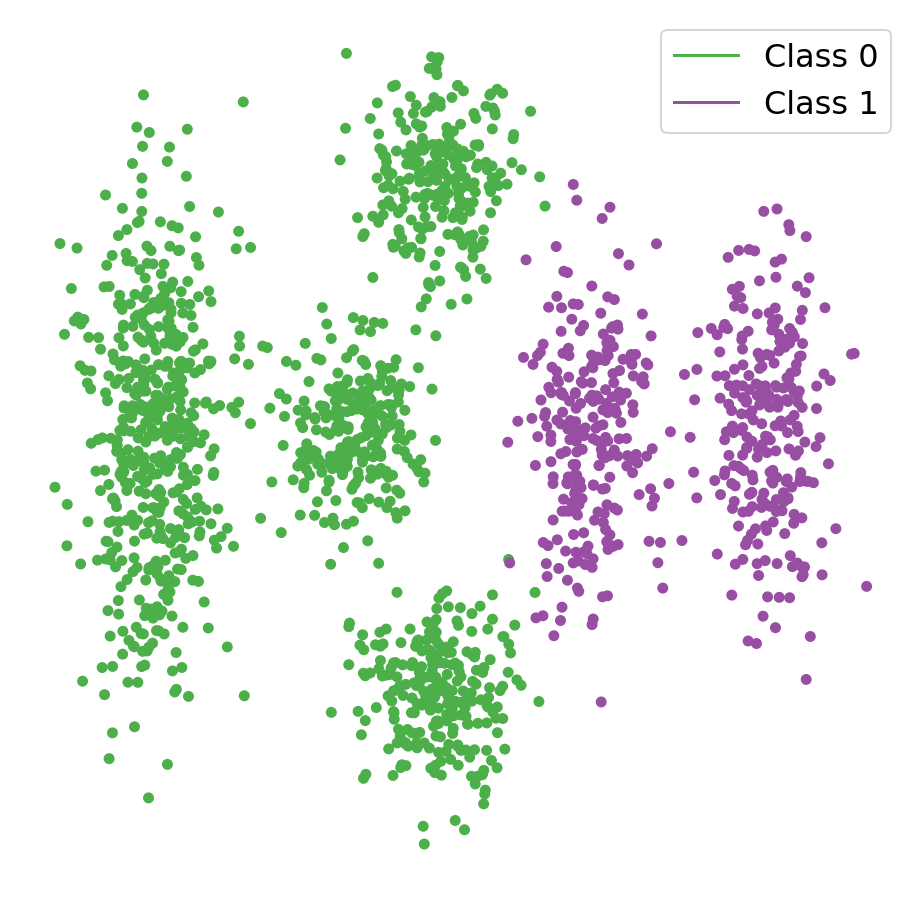

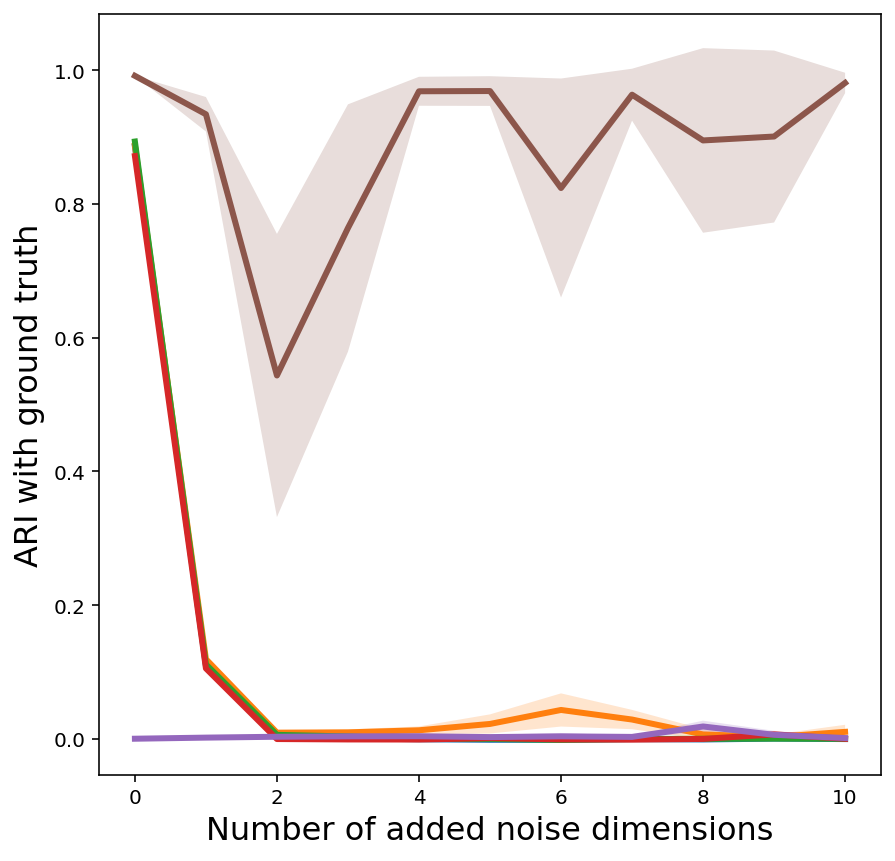

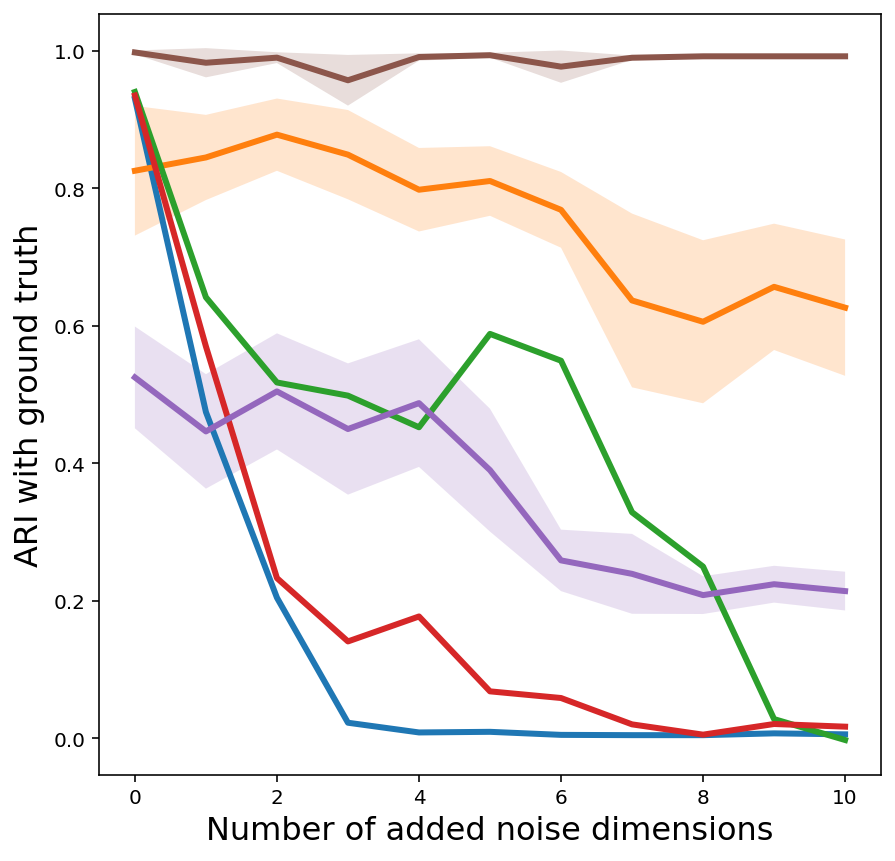

In [15]:
noise_dimensions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dict_metrics = {
                0:{"KMeans":{"mean_list":[], "std_list":[]}, 
                   "GMM":{"mean_list":[], "std_list":[]}, 
                   "DBSCAN":{"mean_list":[], "std_list":[]}, 
                   "AgglomerativeClustering":{"mean_list":[], "std_list":[]}, 
                   "HYDRA":{"mean_list":[], "std_list":[]} , 
                   "UCSL GMM":{"mean_list":[], "std_list":[]} , 
                   }, 
                
                1:{"KMeans":{"mean_list":[], "std_list":[]} , 
                   "GMM":{"mean_list":[], "std_list":[]} , 
                   "DBSCAN":{"mean_list":[], "std_list":[]}, 
                   "AgglomerativeClustering":{"mean_list":[], "std_list":[]}, 
                   "HYDRA":{"mean_list":[], "std_list":[]} ,
                   "UCSL GMM":{"mean_list":[], "std_list":[]} , 
                   }
               }

n_clusters_per_label={0:2, 1:4}

# dataset creation
X_train, y_train, y_true_cluster = make_gaussian_parallel_convex_concave_dataset(noise_dimensions=0, plot=True)
print('')

for noise_dimension in noise_dimensions :

  if noise_dimension > 0 :
    X_train = np.concatenate((X_train, np.random.normal(0, 1, size=(X_train.shape[0], 1))), 1)

  for clustering_type in ["HYDRA", "GMM", "KMeans", "DBSCAN", "AgglomerativeClustering", "UCSL GMM"] :
    ARIs = {0:[], 1:[]}
    for i in range(1, 10) :
      initialization_matrixes = {}
      initialization_matrixes[0] = np.ones((len(X_train), n_clusters_per_label[0]))/n_clusters_per_label[0]
      initialization_matrixes[1] = np.ones((len(X_train), n_clusters_per_label[1]))/n_clusters_per_label[1]
      
      initialization_matrixes[0][y_train==0] = GaussianMixture(n_components=2, n_init=1).fit(X_train[y_train==0]).predict_proba(X_train[y_train==0])
      initialization_matrixes[1][y_train==1] = GaussianMixture(n_components=4, n_init=1).fit(X_train[y_train==1]).predict_proba(X_train[y_train==1])

      # different method training
      if clustering_type == 'HYDRA' :
        UCSL_method = UCSL_C(initialization="precomputed", n_consensus=1, n_iterations=20,  clustering="HYDRA", maximization="max_margin", negative_weighting="all",
                             n_clusters_per_label={0:2, 1:4}, custom_initialization_matrixes=initialization_matrixes)
        UCSL_method.fit(X_train, y_train)

      elif clustering_type == 'UCSL GMM' : 
        UCSL_method = UCSL_C(initialization="precomputed", n_consensus=1, n_iterations=20, noise_tolerance_threshold=6,
                             n_clusters_per_label={0:2, 1:4}, custom_initialization_matrixes=initialization_matrixes, positive_weighting="hard_clustering")
        UCSL_method.fit(X_train, y_train)

      elif clustering_type == 'KMeans' : 
        clustering_method = [KMeans(n_clusters=n_clusters_per_label[i]).fit(X_train[y_train==i]) for i in [0, 1]]

      elif clustering_type == 'GMM' : 
        clustering_method = [GaussianMixture(n_components=n_clusters_per_label[i]).fit(X_train[y_train==i]) for i in [0, 1]]

      for label in [0, 1] :
        if clustering_type in ['HYDRA', 'UCSL GMM'] : 
          y_pred = np.argmax(UCSL_method.predict_clusters(X_train)[label], 1)[y_train==label]
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

        elif clustering_type in ['KMeans', 'GMM'] :
          y_pred = clustering_method[label].predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred)) , 

        elif clustering_type in ['DBSCAN'] :
          y_pred = SpectralClustering(n_clusters=n_clusters_per_label[label]).fit_predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

        elif clustering_type in ['AgglomerativeClustering'] :
          y_pred = AgglomerativeClustering(n_clusters=n_clusters_per_label[label]).fit_predict(X_train[y_train==label])
          ARIs[label].append(ARI(y_true_cluster[label], y_pred))

    for label in [0, 1] :
      dict_metrics[label][clustering_type]["mean_list"].append(np.mean(ARIs[label]))
      dict_metrics[label][clustering_type]["std_list"].append(np.std(ARIs[label]))


%config InlineBackend.figure_format = 'retina'

for label in [0, 1] :
  plt.figure(figsize=(7, 7))
  for clustering_type in ["KMeans", "GMM", "DBSCAN", "AgglomerativeClustering", "HYDRA", "UCSL GMM"] :
    ARI_mean_list = gaussian_filter1d(np.array(dict_metrics[label][clustering_type]["mean_list"]), 0.5)
    ARI_std_list = gaussian_filter1d(np.array(dict_metrics[label][clustering_type]["std_list"]), 0.5) / 2
    plt.plot(noise_dimensions, ARI_mean_list, linestyle='-', label=clustering_type, linewidth=3)
    plt.fill_between(noise_dimensions, ARI_mean_list-ARI_std_list, ARI_mean_list+ARI_std_list, alpha=0.2)
  plt.xlabel("Number of added noise dimensions", fontsize=16)
  plt.ylabel("ARI with ground truth", fontsize=16)
  #plt.legend(prop={'size': 15})
  plt.show()
  print('')